<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/otimiza%C3%A7%C3%A3o_caraga_caminh%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# **Otimização de Cargas com Algoritimo Genéticos**


---


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_f77572eb85d049688987c967d9038104~mv2.jpg"></p>




In [133]:
!pip install deap -q

In [134]:
import numpy as np
import random
import pandas as pd
from deap import base, creator, algorithms, tools
import matplotlib.pyplot as plt
import seaborn as sns

#configurações de gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Importando os dados

In [135]:
!pip install kaggle -q

In [ ]:
from google.colab import files
files.upload()

In [137]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [138]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)


In [139]:
!ls

 brazilian-ecommerce.zip   files  'kaggle (1).json'   kaggle.json   sample_data


In [140]:
import zipfile
zip_ref = zipfile.ZipFile('brazilian-ecommerce.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [169]:
df_items = pd.read_csv('/content/files/olist_order_items_dataset.csv')
df_produto = pd.read_csv('/content/files/olist_products_dataset.csv')

In [142]:
print(df_items.shape)
df_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [143]:
print(df_produto.shape)
df_produto.head()

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Prepararo do dataset

In [170]:
#Escolher variáleis as necesárias
df_items = df_items.iloc[:, [2,5,6]]
df_produto = df_produto.iloc[:, [0,1,5,6,7,8]]

In [171]:
#Indexar o id do produto
df_items = df_items.set_index('product_id')
df_produto = df_produto.set_index('product_id')

In [172]:
 #Realizar um join entre as tabelas
 df = df_items.join(df_produto)

In [173]:
#Calcular o volume e preço total de cada produto
df["volume"] = df["product_length_cm"]*df["product_height_cm"]*df["product_width_cm"]
df["preco"] =  df["price"]+df["freight_value"]
df = df.reset_index()

In [174]:
#Escolher dataset final
produtos = df.iloc[:, [0,3, 4 ,8,9]]
produtos.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
1,00088930e925c41fd95ebfe695fd2655,automotivo,1225.0,14300.0,143.83
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
4,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50


## Criando o Algoritimo Genético

Tipo de caminhão VUC
<p align="center"><img src="http://www.guiadotrc.com.br/figuras/vuc-reforcado.gif?gtgggf"></p>



<p align="center"><img src="https://www.truckpad.com.br/uploads/2017/01/329981fc-medidas-carrocerias-3.png"></p>

In [175]:
#lmimte de espaço no caminhão
limtie_espacos = 2.2*7.2*3.5*100  #grandeza em centimetros
limtie_peso = 4e+6   #grandeza em gramas

In [176]:
#Criar Classe do Produto
class Produto():
    def __init__(self, nome, pesos, volume, valores):
        self.nome = nome
        self.pesos = pesos 
        self.volume = volume
        self.valor = valor

In [177]:
#Criando listas de produtos
lista_produtos = []

for i in range(len(produtos)):
  lista_produtos.append(produtos.loc[i])

In [178]:
#Transformar em listas
espacos = list(produtos.volume)
valores = list(produtos.preco)
nome = list(produtos.product_id)
pesos = list(produtos.product_weight_g)

In [179]:
#Criar a função de avaliação
def avaliacao(individual):
    nota = 0 
    soma_espacos = 0
    soma_pesos = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            nota += valores[i]
            soma_espacos += espacos[i]
            soma_pesos += pesos[i]
            
    if soma_espacos > limtie_espacos and soma_pesos > limtie_peso:
      nota = 1

    return nota / 100000, 

In [ ]:
#Criar a toolbox
toolbox = base.Toolbox()

#Criando parâmetros na toolbox
creator.create("FitnessMax",  base.Fitness, weights = (1.0, ))
creator.create("Individual", list, fitness = creator.FitnessMax)

#Registrando na toolbox
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n = len(espacos))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", avaliacao)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.05)
toolbox.register("select", tools.selRoulette)

In [181]:
#Iniciando a toolbox
if __name__ == "__main__":
    population = toolbox.population(n = 24)
    probabilidade_crossover = 5.0
    probabilidade_mutação = 0.03
    numero_gerações = 250
    
    estatisticas = tools.Statistics( key = lambda individuo: individuo.fitness.values)
    estatisticas.register("max", np.max)
    estatisticas.register("min", np.min)
    estatisticas.register("med", np.mean)
    estatisticas.register("std", np.std)
    
    populacao, info = algorithms.eaSimple(population, toolbox, 
                                          probabilidade_crossover, 
                                          probabilidade_mutação,
                                          numero_gerações, estatisticas)

gen	nevals	max    	min    	med    	std     
0  	24    	80.5387	78.0217	79.1141	0.515631
1  	24    	80.2798	78.53  	79.212 	0.426762
2  	24    	79.9195	78.4214	79.0989	0.350674
3  	24    	79.6193	78.4137	79.0792	0.308868
4  	24    	79.7415	78.598 	79.1462	0.308654
5  	24    	79.8293	78.7173	79.2017	0.271295
6  	24    	79.5867	78.718 	79.1473	0.203826
7  	24    	79.7402	78.7045	79.1637	0.231724
8  	24    	80.0889	78.9228	79.2351	0.280823
9  	24    	79.8132	78.7728	79.2176	0.261805
10 	24    	79.6355	78.6872	79.1635	0.237934
11 	24    	79.5254	78.7979	79.1658	0.181442
12 	24    	79.5201	78.7406	79.1319	0.191937
13 	24    	79.4829	78.7101	79.1944	0.207276
14 	24    	79.6204	78.8156	79.1396	0.221743
15 	24    	79.5486	78.6049	79.105 	0.23208 
16 	24    	79.4594	78.4575	79.0542	0.280349
17 	24    	79.564 	78.4575	79.0961	0.305902
18 	24    	79.543 	78.4823	79.0448	0.242588
19 	24    	79.5909	78.517 	79.0816	0.236093
20 	24    	79.6361	78.7585	79.0619	0.225111
21 	24    	79.5429	78.5986	79.00

In [182]:
#Identificando o melhor indivíduo
melhores = tools.selBest(populacao, 1)

for individuo in melhores:
    df_otimizado = []
    soma = 0
    indi = 0
    for i in range (len(lista_produtos)):
        if individuo[i] == 1:
            soma += valores[i]
            indi += individuo[i]
            df_otimizado.append(lista_produtos[i])

    print("---")
    print(individuo.fitness)
    print("Valor total do Indivíduo: R$", soma)
    print("Número Indivíduo:", indi)

---
(79.90174549999695,)
Valor total do Indivíduo: R$ 7990174.549999695
Número Indivíduo: 56669


In [183]:
df_otimizado = pd.DataFrame(df_otimizado)
df_otimizado.head()

,product_id,product_category_name,product_weight_g,volume,preco
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,300.0,5120.0,120.24
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,300.0,23625.0,242.10
3,000b8f95fcb9e0096488278317764d19,utilidades_domesticas,550.0,5472.0,78.50
5,000d9be29b5207b54e86aa1b1ac54872,relogios_presentes,250.0,3630.0,218.27
7,00126f27c813603687e6ce486d909d01,cool_stuff,700.0,1875.0,262.24


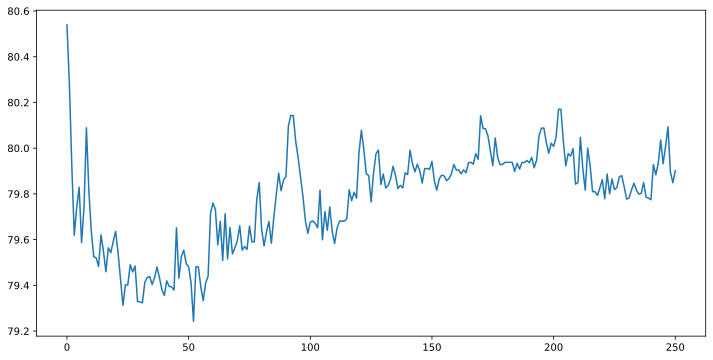

In [184]:
#Plotando o aprendizado
valores_pop = info.select("max")
plt.figure(figsize = (12,6))
plt.plot(valores_pop)
plt.show()